In [1]:
import os, sys
import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("font", size=14)
ccrs.PlateCarree()

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4)
client = Client(cluster)
client


/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39043 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:39043/status,
Dashboard: http://137.129.155.67:39043/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/47199/1,Workers: 1
Dashboard: http://137.129.155.67:39043/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/47199/4,Total threads: 4
Dashboard: http://137.129.155.67:40607/status,Memory: 78.61 GiB
Nanny: None,


In [23]:
latm, latM = -15.1,15.1

def computeProbabilite(latm, latM, ds_skew_mean, lonm = None, lonM = None):
    if lonm != None :
        _ds = ds.sel(lat = slice(latM,latm), lon = slice(lonm,lonM)).persist()
        _ds_anom = ds_anom.sel(lat = slice(latM,latm), lon = slice(lonm,lonM)).persist()
    else :
        _ds = ds.sel(lat = slice(latM,latm)).persist()
        _ds_anom = ds_anom.sel(lat = slice(latM,latm)).persist()
    
    _ds = _ds.sum(dim = ['lat','lon']).compute()
    _ds = _ds.sel(nRange = slice(-10,10))
    
    _ds_anom = _ds_anom.sum(dim = ['lat','lon']).compute()
    _ds_anom = _ds_anom.sel(nRange = slice(-30,30))
    
    Prob = _ds.copy()
    Prob = Prob*0.
    del Prob['time']

    for v in var :
        da = _ds[v]
        Somme = 0
        for i in range(da.nRange.size):
            Somme = Somme + int(da.isel(nRange = i).values)

        Prob[v] = da/Somme

    del Prob['time']

    Prob_T = _ds_anom.copy()
    Prob_T = Prob_T*0.
    # del Prob_T['time']
    Somme = 0
    for i in range(_ds_anom.nRange.size):
        Somme = Somme + int(_ds_anom['tcwv_ano'].isel(nRange = i).values)

    Prob_T['tcwv_ano'] = _ds_anom['tcwv_ano']/Somme

    plt.figure(figsize = (12,10))
    for v in var :
        Prob[v].plot(label = v + ' skewness = ' + str('%.2f' % ds_skew_mean[v]), ylim = [0,0.15])
    plt.legend()
    plt.xlabel('Anomalie')
    plt.ylabel('Probabilité')
    plt.axvline(x = 0, color = 'black' )
    plt.title('Densité de Probabilité pour chaque ondes')
    plt.grid()
    plt.show()
    
    plt.figure(figsize = (12,10))
    Prob_T['tcwv_ano'].plot(label = 'anomalie' + ' skewness = ' + str('%.2f' % ds_skew_mean['tcwv_ano']), ylim = [0,0.025])
    plt.legend()
    plt.xlabel('Anomalie')
    plt.ylabel('Probabilité')
    plt.axvline(x = 0, color = 'black' )
    plt.title('Densité de Probabilité pour l anomalie totale')
    plt.grid()
    plt.show()

In [17]:
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/DISTRIBUTION/TCWV/'

ds_anom = xr.open_mfdataset(indir_data_FILTERED + 'distribution_tcwv_ano_JAS.nc')
ds_anom = ds_anom.rename({'latitude':'lat','longitude':'lon'})

ds = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_MJO_JAS.nc')
# da_EIG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_EIG.nc')
# da_WIG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_WIG.nc')
da_MRG = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_MRG_JAS.nc')
da_Kelvin = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_Kelvin_JAS.nc')
da_Rossby = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_Rossby_JAS.nc')
da_TD = xr.open_mfdataset(indir_data_FILTERED + 'distribution_TCWV_TD_JAS.nc')

# ds['TCWV_EIG'] = da_EIG['TCWV_EIG']
# ds['TCWV_WIG'] = da_WIG['TCWV_WIG']
ds['TCWV_MRG'] = da_MRG['TCWV_MRG']
ds['TCWV_Kelvin'] = da_Kelvin['TCWV_Kelvin']
ds['TCWV_Rossby'] = da_Rossby['TCWV_Rossby']
ds['TCWV_TD'] = da_TD['TCWV_TD']

# ds = ds.squeeze('variable')
var = ['TCWV_MRG','TCWV_Kelvin','TCWV_Rossby','TCWV_TD','TCWV_MJO']
ds_anom

<xarray.Dataset>
Dimensions:   (nRange: 241, lat: 41, lon: 180)
Coordinates:
  * nRange    (nRange) float64 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
  * lat       (lat) float32 40.0 38.0 36.0 34.0 32.0 ... -34.0 -36.0 -38.0 -40.0
  * lon       (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    time      datetime64[ns] ...
Data variables:
    tcwv_ano  (nRange, lat, lon) float64 dask.array<chunksize=(241, 41, 180), meta=np.ndarray>

In [18]:
from scipy.stats import skew
ds_skew = ds.reduce(skew,dim=('nRange'))
np.float(ds_skew_mean['TCWV_MJO'].values)

da_skew_anom = ds_anom['tcwv_ano'].reduce(skew,dim=('nRange'))
ds_skew['tcwv_ano'] = da_skew_anom

ds_skew_mean = ds_skew.mean(dim = ['lat', 'lon'])
ds_skew_mean

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    time         datetime64[ns] ...
Data variables:
    TCWV_MJO     float32 4.32
    TCWV_MRG     float32 4.535
    TCWV_Kelvin  float32 3.206
    TCWV_Rossby  float32 3.426
    TCWV_TD      float32 4.137
    tcwv_ano     float64 1.303

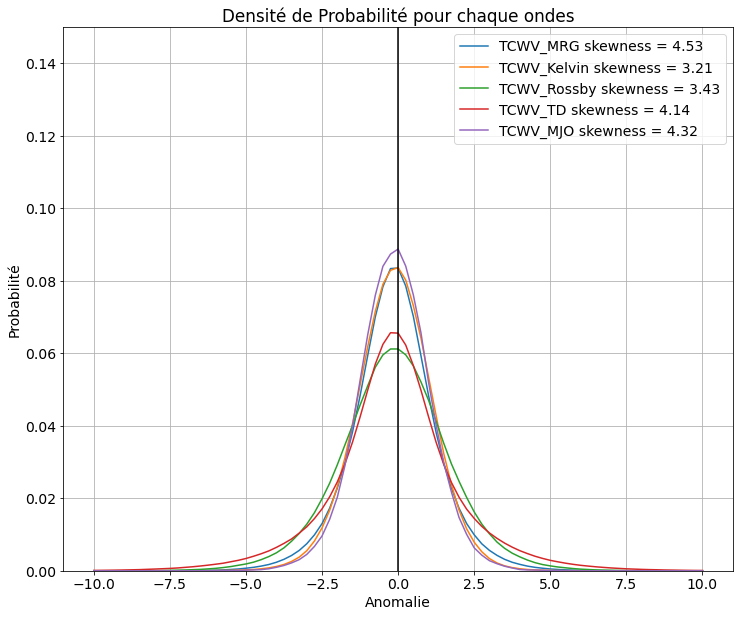

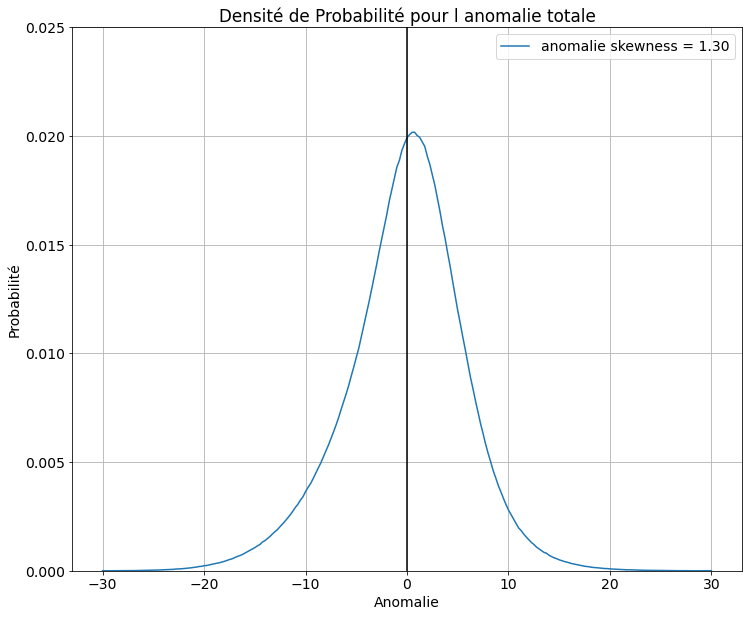

In [24]:
latm, latM = 0,15.1
computeProbabilite(latm,latM, ds_skew_mean)

# Pour la zone 1 
## lat = 0 °N à 20 °N et lon = 100 °E à 180°E

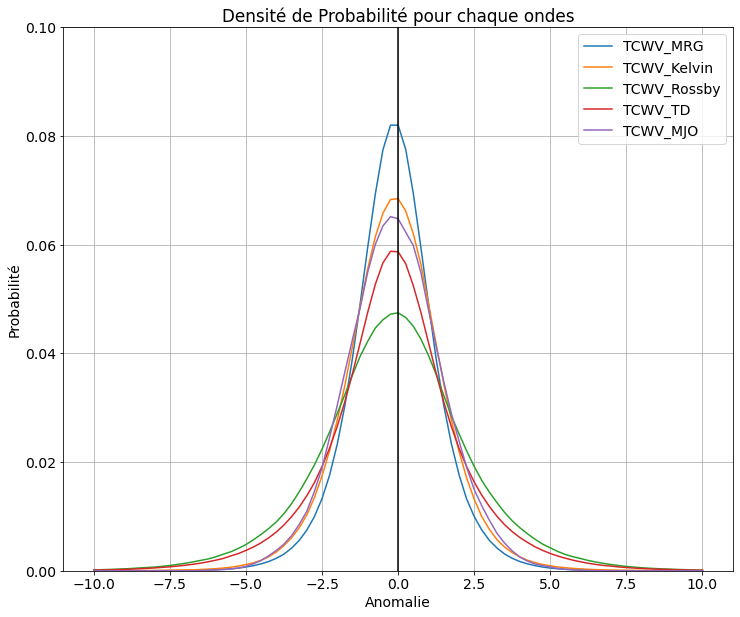

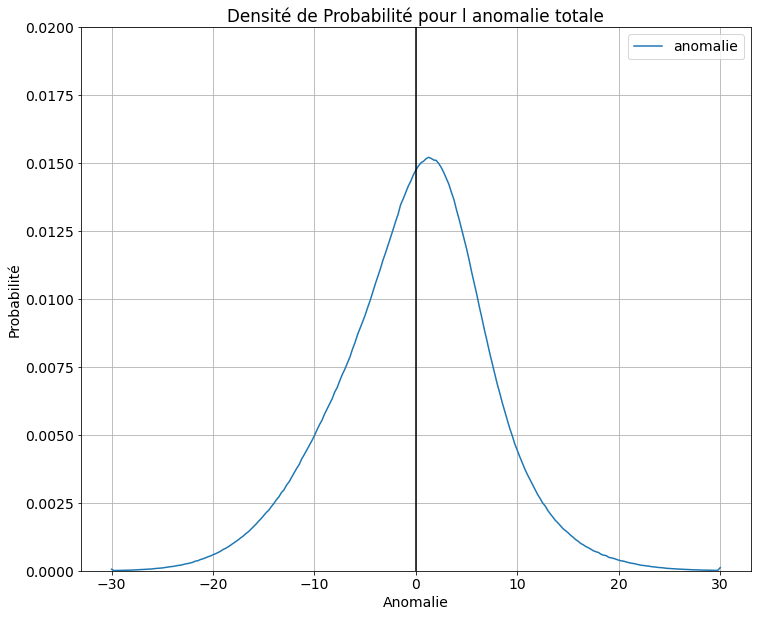

In [5]:
latm, latM = 0,20
lonm, lonM = 100, 180
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 2
## lat = 0 °N à 20 °N et lon = 180 °E à 270 °E

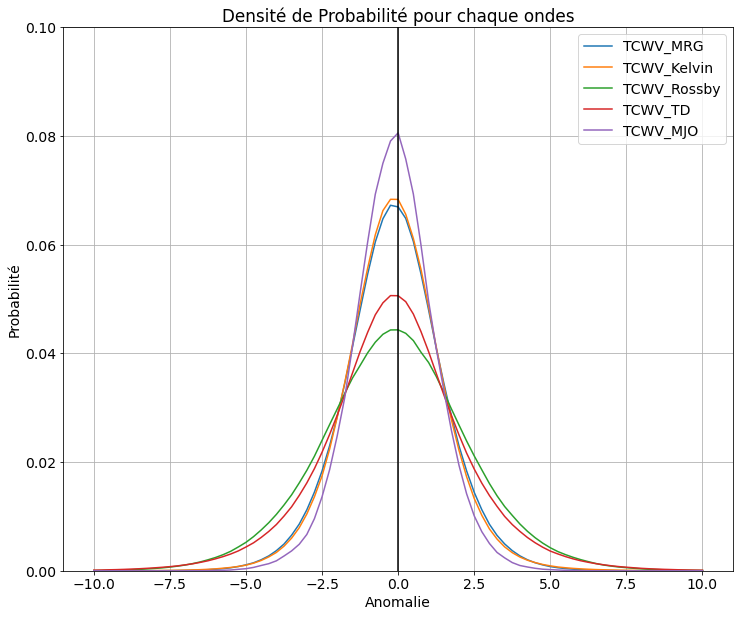

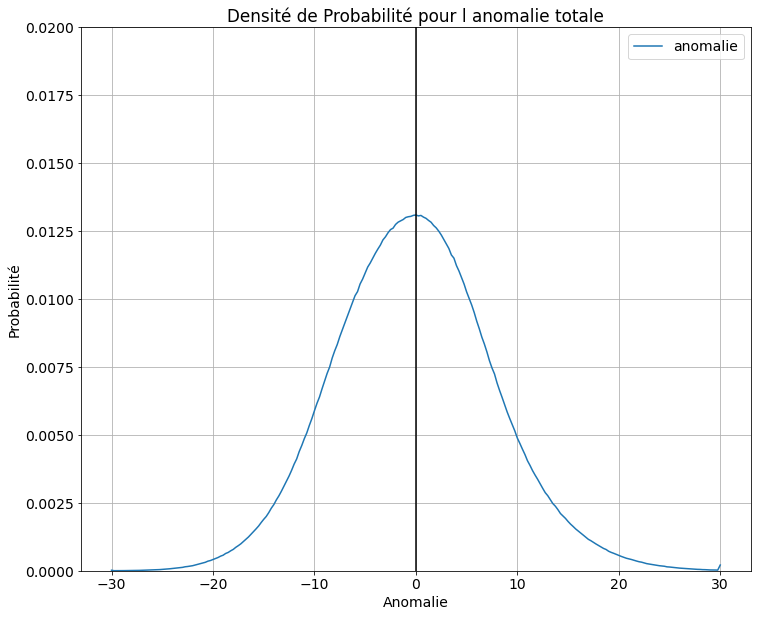

In [6]:
latm, latM = 0,20
lonm, lonM = 180, 270
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 3
## lat = 0 °N à 20 °N et lon = 270 °E à 360 °E

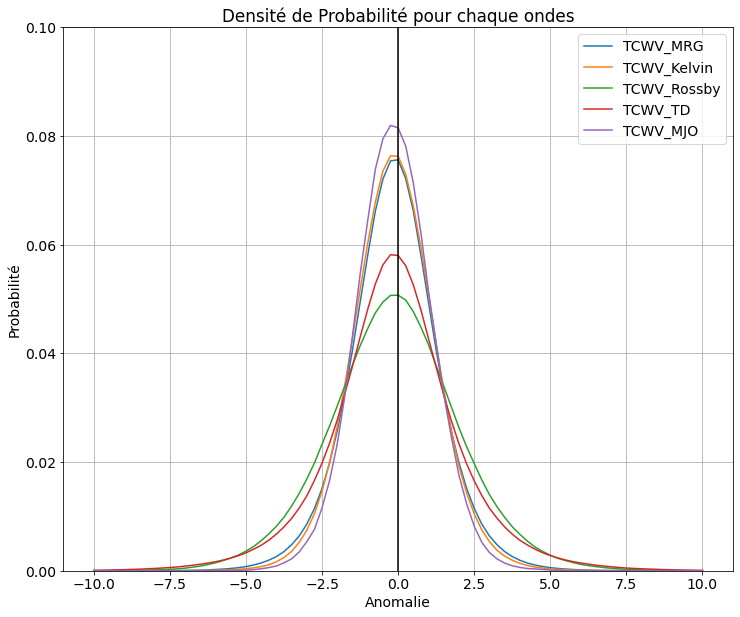

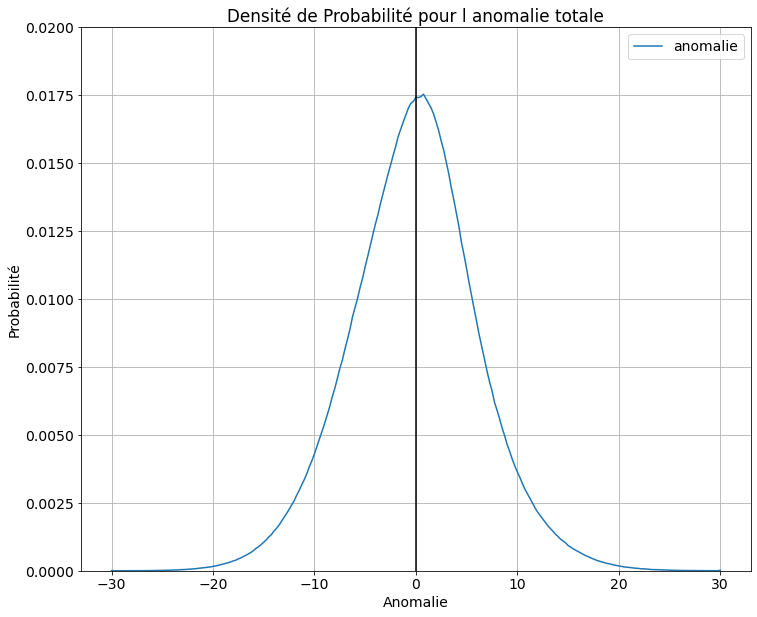

In [7]:
latm, latM = 0,20
lonm, lonM = 270, 360
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 3
## lat = 0 °N à 20 °N et lon = 0 °E à 100 °E

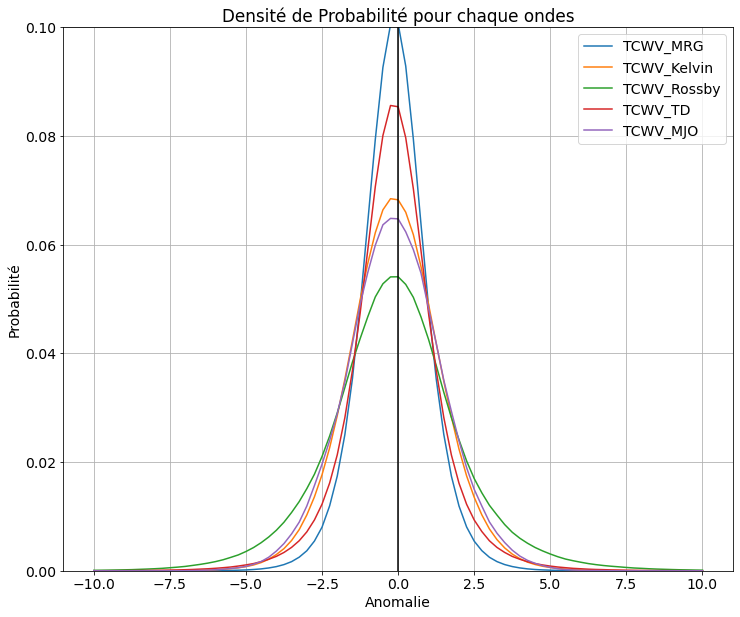

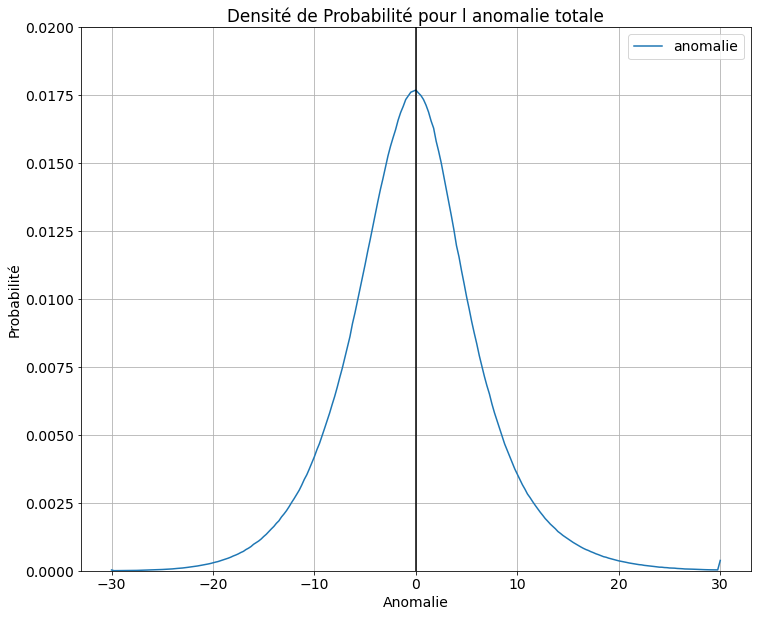

In [8]:
latm, latM = 0,20
lonm, lonM = 0, 100
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 4
## lat = 0 °S à 20 °S et lon = 0 °E à 135 °E

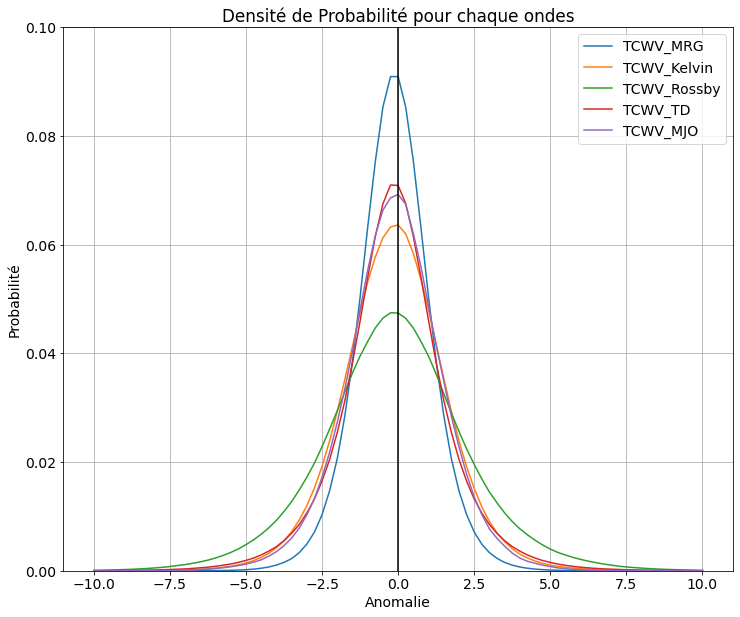

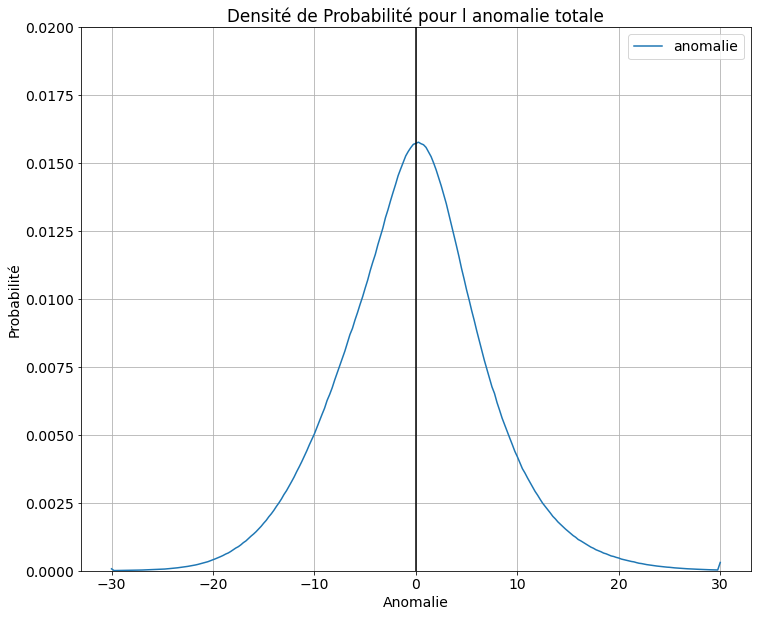

In [9]:
latm, latM = -20,0
lonm, lonM = 0, 135
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Pour la zone 5
## lat = 0 °S à 20 °S et lon = 135 °E à 360 °E

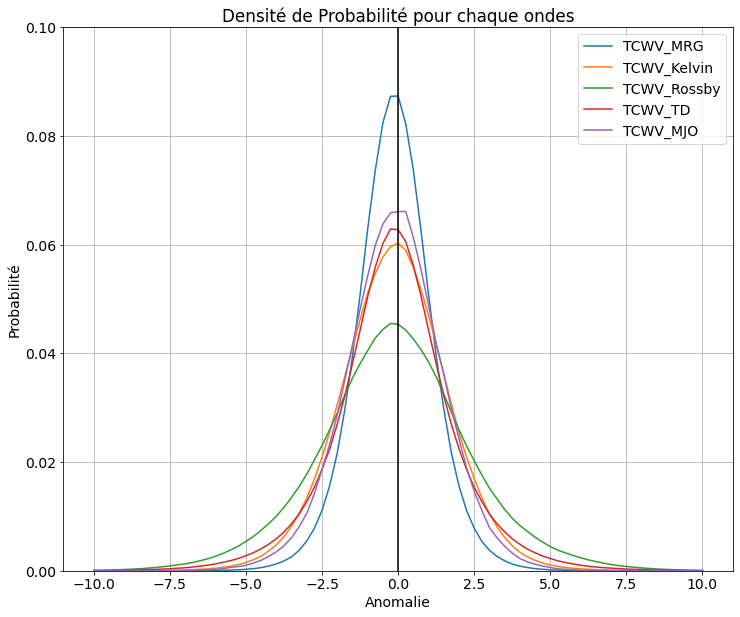

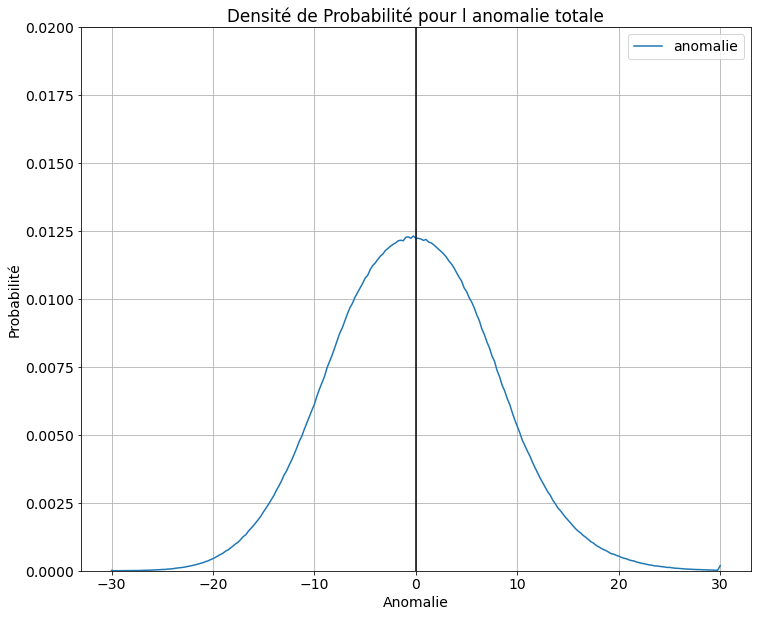

In [10]:
latm, latM = -20,0
lonm, lonM = 40, 90
computeProbabilite(latm,latM, lonm = lonm, lonM = lonM)

# Suite pour les valeurs Brut

In [20]:
ds_BRUT = xr.open_mfdataset(indir_data_FILTERED + 'distribution_BRUT_tcwv_JAS.nc')
ds_BRUT

<xarray.Dataset>
Dimensions:    (nRange: 161, longitude: 180, latitude: 91)
Coordinates:
  * nRange     (nRange) float64 0.0 0.5 1.0 1.5 2.0 ... 78.0 78.5 79.0 79.5 80.0
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
    time       datetime64[ns] ...
Data variables:
    tcwv       (nRange, latitude, longitude) float32 dask.array<chunksize=(161, 91, 180), meta=np.ndarray>

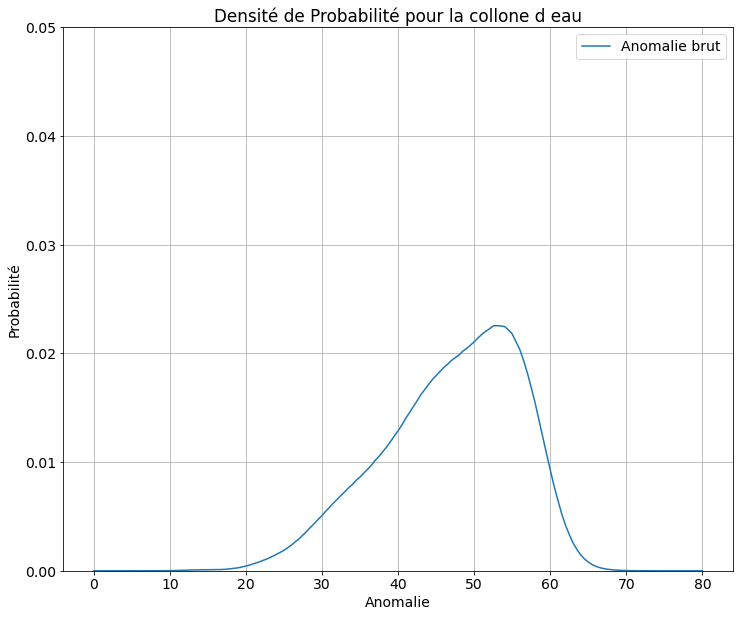

In [22]:
ds_BRUT = ds_BRUT.sel(latitude = slice(15.1,0)).persist()
_ds_BRUT = ds_BRUT.sum(dim = ['latitude','longitude']).compute()

Prob_BRUT = _ds_BRUT.copy()
Prob_BRUT = Prob_BRUT * 0.
# del Prob_T['time']
Somme = 0
for i in range(Prob_BRUT.nRange.size):
    Somme = Somme + int(_ds_BRUT['tcwv'].isel(nRange = i).values)

Prob_BRUT['tcwv'] = _ds_BRUT['tcwv']/Somme

plt.figure(figsize = (12,10))
Prob_BRUT['tcwv'].plot(label = 'Anomalie brut', ylim = [0,0.05])
# _ds_anom['Sum_FILTER'].plot(label = 'Somme Filtre')
plt.legend()
plt.xlabel('Anomalie')
plt.ylabel('Probabilité')
plt.title('Densité de Probabilité pour la collone d eau')
plt.grid()
plt.show()

In [13]:
ds_BRUT['tcwv'].isel(latitude = 0, longitude = 0).values

array([  0.,   0.,   0.,   0.,   0.,   5.,  20.,  53.,  90., 187., 267.,
       385., 434., 493., 605., 636., 687., 690., 722., 733., 839., 806.,
       758., 703., 737., 713., 764., 739., 755., 720., 721., 649., 612.,
       622., 550., 522., 480., 466., 468., 377., 386., 352., 291., 301.,
       273., 299., 270., 233., 251., 217., 226., 219., 248., 240., 249.,
       257., 243., 242., 267., 283., 263., 226., 278., 280., 294., 290.,
       305., 304., 301., 357., 343., 391., 384., 444., 409., 468., 420.,
       452., 478., 500., 510., 532., 514., 584., 599., 600., 632., 668.,
       674., 637., 676., 617., 606., 595., 558., 592., 512., 514., 489.,
       395., 325., 310., 305., 258., 223., 171., 144., 115.,  95.,  74.,
        67.,  44.,  25.,  25.,  19.,  20.,  13.,   3.,   4.,   3.,   1.,
         1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   